Saving imgg1.jpg to imgg1 (2).jpg
Saving imgg2.jpg to imgg2.jpg


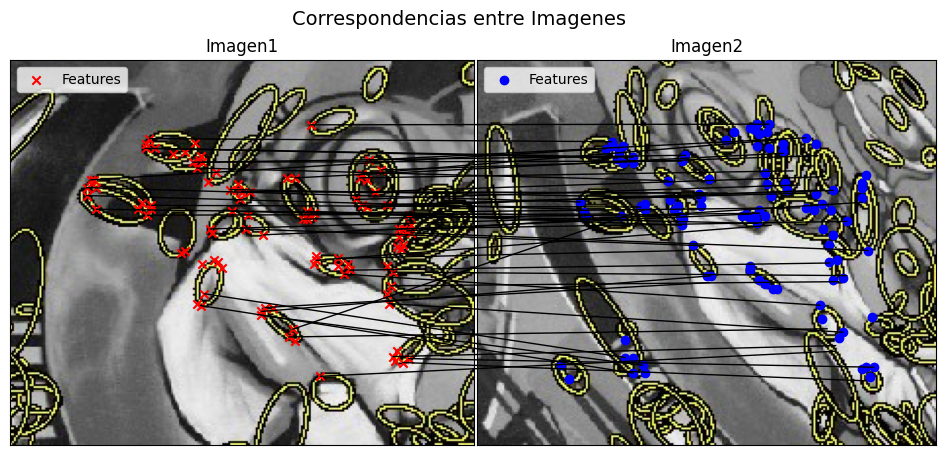

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from matplotlib.patches import ConnectionPatch

from google.colab import files
import matplotlib.image as mpimg
uploaded = files.upload()

#Cargar imagenes
i1 = "imgg1.jpg"
i2 = "imgg2.jpg"
img1 = cv2.imread(i1, cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(i2, cv2.IMREAD_GRAYSCALE)

#Deteccion de las caracteristicas de las imagenes
detector_features = cv2.ORB_create()
k_1, d_1 = detector_features.detectAndCompute(img1, None)
k_2, d_2 = detector_features.detectAndCompute(img2, None)

features_1 = np.array([par.pt for par in k_1])
features_2 = np.array([par.pt for par in k_2])

#Calculo de distancias entre las caracteristicas
rij = cdist(features_1, features_2)

#Construccion de la matriz G de proximidad
sigma = 40
m = len(features_1)
n = len(features_2)
G = np.zeros((m,n))
for i in range(m):
  for j in range(n):
    G[i,j] = np.exp((-rij[i,j]**2)/(2*sigma**2))

#Calculo de la SVD de G:
U, s, vt = np.linalg.svd(G)
p = len(s)
S = np.zeros((m,n))
S[:p, :p] = np.diag(s)

#Construccion de la matriz P de emparejamiento:
E = np.copy(S)
E[:p, :p] = np.eye(p)
P = U @ E @ vt

#Graficos
#parte imagenes
img1 = mpimg.imread(i1)
img2 = mpimg.imread(i2)
ancho = []
alto = []
for i, img in zip([0,1], [img1, img2]):
  alto_i, ancho_i = img.shape[:2]  #.shape() devuelve una terna con alto, ancho y el nro 3 que hace referencia a los colores RGB, por eso ponemos [:2]
  alto.append(alto_i)
  ancho.append(ancho_i)

#parte caracteristicas

fig, ejes = plt.subplots(1, 2, figsize=(12, 5))
fig.subplots_adjust(wspace=0)   #esto hace que los graficos estes pegados
fig.suptitle("Correspondencias entre Imagenes", fontsize=14)
col = ["red", "blue"]
fts = [features_1, features_2]
dib = ["x", "o"]
for i, img in zip([0,1], [img1, img2]):
  ejes[i].imshow(img, extent=[0, ancho[i], alto[i], 0]) #img es la matriz que representa la imagen que queremos poner de fondo y extent nos da el tamaño del
                                                        #plano XY de maplotlib que cubre la imagen, por eso ponemos el tamaño de la imagen, para que no se deforme

  ejes[i].scatter(fts[i][:100, 0], fts[i][:100, 1],
                c= col[i], marker= dib[i], label='Features')
  ejes[i].legend(loc="upper left")
  ejes[i].set_title(f"Imagen{i+1}")
  ejes[i].set_xticks([])   #xticks() e yticks() permiten renombrar los ejes, por ej poner nomobres de los meses, etc
  ejes[i].set_yticks([])   #si el argumento es una lista vacia, se eliminan los ejes visualmente (saque los nros para que quede mas prolijo)

j_max = np.argmax(P, axis=1)  #lista de índices de las columnas donde esta el maximo de las filas (maximo en cada fila)
i_max = np.argmax(P, axis=0)  #lista de índices de las filas donde esta el maximo de las columnas (maximo en cada columna)
for i in range(100): #se recorren las filas
    j = j_max[i]     #j es el indice del elemento maximo de la fila i, o sea el maximo de la fila i esta en la columna j
    x_coords = [features_1[i, 0], features_2[j, 0]] #agrupamos las coordenadas x de ambas imagenes por un lado, y las coordenadas y por otro
    y_coords = [features_1[i, 1], features_2[j, 1]]

    if i == i_max[j]: #i es el indice del elemento maximo de la columna j, queremos ver si el maximo de la columna j esta en la fila i

        con1 = ConnectionPatch(xyA=(x_coords[1], y_coords[1]),  #se unen los puntos origen xyB (caracteristicas de la imagen 1), con los puntos destino xyA
                              coordsA=ejes[1].transData,        #con los puntos destino xyA (caracteristicas de la imagen 2)
                               xyB=(x_coords[0], y_coords[0]),
                               coordsB=ejes[0].transData,
                              color="black", linestyle="-")
        fig.add_artist(con1)

plt.show()